In [1]:
# My py files
import env
import os
import wrangle as w
# Load Datasets
from pydataset import data
# Ignore Warning
import warnings
warnings.filterwarnings("ignore")
# Array and Dataframes
import numpy as np
import pandas as pd
# Imputer
from sklearn.impute import SimpleImputer
# Evaluation: Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Evaluation: Statistical Analysis
from scipy import stats
# Modeling: Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
# Modeling: Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE
# Modeling
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import GridSearchCV
# Metrics
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

# 1. Load the tips dataset.

In [2]:
tips = data('tips')

In [3]:
train, validate, test = w.splitter(tips)

Dataframe: (244, 7) 100%
Train: (156, 7) | ~60%
Validate: (39, 7) | ~20%
Test: (49, 7) | ~20%


In [4]:
train.head()

,total_bill,tip,sex,smoker,day,time,size
86,34.83,5.17,Female,No,Thur,Lunch,4
113,38.07,4.00,Male,No,Sun,Dinner,3
194,15.48,2.02,Male,Yes,Thur,Lunch,2
227,10.09,2.00,Female,Yes,Fri,Lunch,2
231,24.01,2.00,Male,Yes,Sat,Dinner,4


### a. Create a column named price_per_person. This should be the total bill divided by the party size.

In [5]:
train['price_per_person'] = train['total_bill']/train['size']

In [6]:
dummy_df = pd.get_dummies(train[['sex','smoker','day','time']],dtype=int,drop_first=True)

In [7]:
train = pd.concat([train, dummy_df], axis=1)

<Axes: >

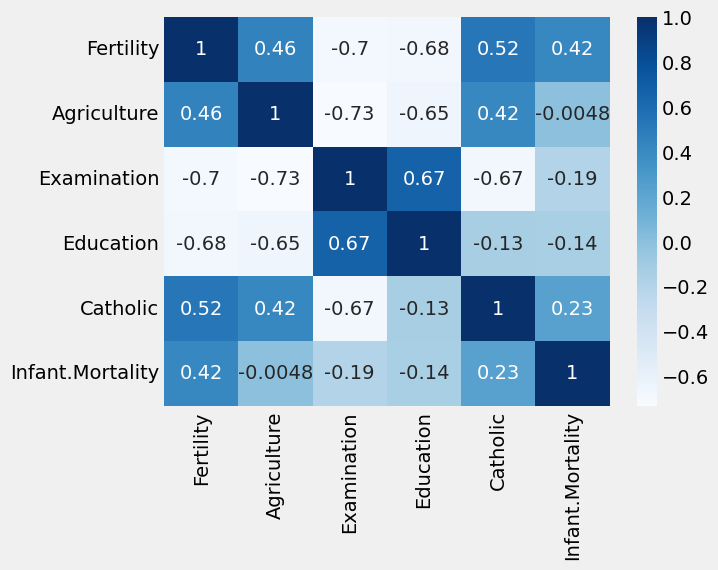

In [48]:
sns.heatmap(train.corr(),cmap='Blues',annot=True)

In [8]:
train.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
86,34.83,5.17,Female,No,Thur,Lunch,4,8.7075,0,0,0,0,1,1
113,38.07,4.00,Male,No,Sun,Dinner,3,12.6900,1,0,0,1,0,0
194,15.48,2.02,Male,Yes,Thur,Lunch,2,7.7400,1,1,0,0,1,1
227,10.09,2.00,Female,Yes,Fri,Lunch,2,5.0450,0,1,0,0,0,1
231,24.01,2.00,Male,Yes,Sat,Dinner,4,6.0025,1,1,1,0,0,0


In [9]:
x_train = train.drop(columns=['tip','sex','smoker','day','time'])
y_train = train.tip
x_train.head()

,total_bill,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
86,34.83,4,8.7075,0,0,0,0,1,1
113,38.07,3,12.6900,1,0,0,1,0,0
194,15.48,2,7.7400,1,1,0,0,1,1
227,10.09,2,5.0450,0,1,0,0,0,1
231,24.01,4,6.0025,1,1,1,0,0,0


In [10]:
mms = MinMaxScaler()

In [11]:
x_train_scaled = mms.fit_transform(x_train)
x_train_scaled

array([[0.70172338, 0.6       , 0.33520115, ..., 0.        , 1.        ,
        1.        ],
       [0.77330977, 0.4       , 0.56408046, ..., 1.        , 0.        ,
        0.        ],
       [0.27419355, 0.2       , 0.2795977 , ..., 0.        , 1.        ,
        1.        ],
       ...,
       [0.43482103, 0.2       , 0.48850575, ..., 0.        , 0.        ,
        0.        ],
       [0.38002651, 0.2       , 0.41724138, ..., 0.        , 1.        ,
        1.        ],
       [0.36632788, 0.2       , 0.39942529, ..., 0.        , 0.        ,
        0.        ]])

### b. Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?

In [12]:
# total_bill & size

### c. Use Select K Best to select the top 2 features for predicting tip amount. What are they?

In [13]:
# parameters: f_regression stats test, give me all features - normally int

f_selector = SelectKBest(f_regression, k=2)#k='all')
# find the all X's correlated with y
f_selector.fit(x_train_scaled, y_train)

# boolean mask of whether the column was selected or not
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = x_train.iloc[:,feature_mask].columns.tolist()

In [14]:
f_feature

['total_bill', 'size']

### d. Use Recursive Feature Elimination to select the top 2 features for tip amount. What are they?

In [15]:
lr = lr()

In [16]:
# create the rfe object, indicating the ML object (lr) and the number of features I want to end up with. 
rfe = RFE(lr, n_features_to_select=2)

# fit the data using RFE
rfe.fit(x_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = x_train.iloc[:,feature_mask].columns.tolist()

In [17]:
rfe_feature

['total_bill', 'price_per_person']

### e. Why do you think Select K Best and Recursive Feature Elimination might give different answers for the top features? Does this change as you change the number of features you are selecting?

In [ ]:
# Select K Best will 

## 2. Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [30]:
def select_kbest(x_train=x_train_scaled, y_train=y_train, k=2):

    # parameters: f_regression stats test, give me all features - normally in
    f_selector = SelectKBest(f_regression, k=k)#k='all')
    # find the all X's correlated with y
    f_selector.fit(x_train, y_train)

    # boolean mask of whether the column was selected or not
    feature_mask = f_selector.get_support()

    # get list of top K features. 
    f_feature = x_train.iloc[:,feature_mask].columns.tolist()

    return f_feature

## 3. Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top n features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [49]:
def rfe(x_train=x_train_scaled,y_train=y_train, k=2):
    # create the rfe object, indicating the ML object (lr) and the number of features I want to end up with. 
    rfe = RFE(lr, n_features_to_select=n_features)

    # fit the data using RFE
    rfe.fit(x_train,y_train)  

    # get the mask of the columns selected
    feature_mask = rfe.support_

    # get list of the column names. 
    rfe_feature = x_train.iloc[:,feature_mask].columns.tolist()

    return rfe_feature

## 4. Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both Select K Best and Recursive Feature Elimination (use the functions you just built to help you out).

In [22]:
swiss = data('swiss')

In [23]:
train, validate, test = w.splitter(swiss)

Dataframe: (47, 6) 100%
Train: (29, 6) | ~60%
Validate: (8, 6) | ~20%
Test: (10, 6) | ~20%


In [25]:
train.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
V. De Geneve,35.0,1.2,37,53,42.34,18.0
Delemont,83.1,45.1,6,9,84.84,22.2
Herens,77.3,89.7,5,2,100.00,18.3
Glane,92.4,67.8,14,8,97.16,24.9
ValdeTravers,67.6,18.7,25,7,8.65,19.5


In [26]:
x_train = train.drop(columns='Fertility')
y_train = train.Fertility

In [35]:
select_kbest(x_train,y_train, k='all')

['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']

In [39]:
rfe(x_train,y_train, n_features=3)

['Education', 'Catholic', 'Infant.Mortality']